C:\Users\Sudarshan Gogoi\anaconda3\lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


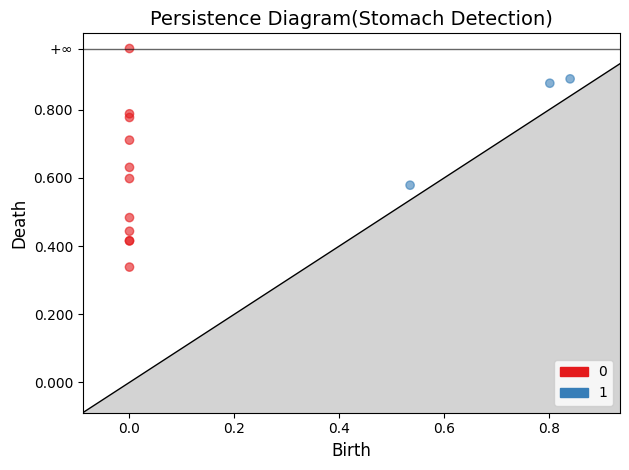

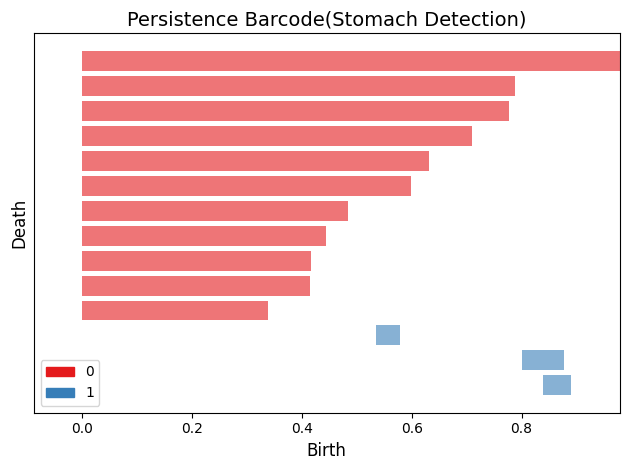

Feature vector saved successfully to D:\My PhD Folder 3rd Paper\Clinical cancer data Test\Test\Clinical cancer data_StomachDet.csv
Cancer detection and Stomach Cancer detection result saved successfully.


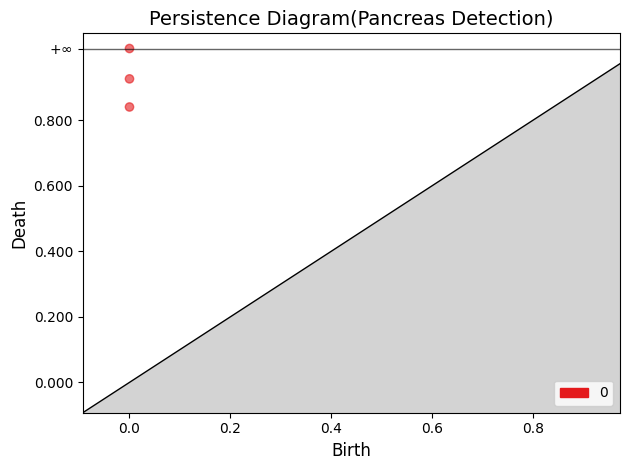

Feature vector saved successfully to D:\My PhD Folder 3rd Paper\Clinical cancer data Test\Test\Clinical cancer data_PancreasDet.csv
The Pancreas cancer detection results have been written to the CSV file successfully.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from ripser import Rips
from ripser import ripser
import matplotlib.pyplot as plt
import gudhi
import csv
from persim import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
import math
from scipy.stats import linregress

def TDAcancer_detect(file_path):
    try:
        # Step 1: Load the patients' data sheet from the provided Excel file 'Clinical cancer data.xlsx'
        sheet_name_1 = 'Normal and Cancer'
        df_1 = pd.read_excel(file_path, sheet_name=sheet_name_1)        
        # Step 2: Select rows 0 to 59 from df_1 to fix a dataset for 59 normal patients
        df_1 = df_1.iloc[:59]
        df_2 = pd.read_excel(file_path, sheet_name=sheet_name_1)
         # Step 3: Select the biomarkers
        columns_to_select = ['CA-125', 'CA 15-3', 'CA19-9', 'CEA', 'CYFRA 21-1', 'FGF2', 'HE4', 'HGF', 'IL-6', 'IL-8', 'TGFa']
        columns_to_select_2 = ['CA19-9', 'CEA', 'TGFa']
        df_1_selected = df_1[columns_to_select]
        df_2_selected = df_2[columns_to_select]        
        ## Process data for the detection of cancer and origin of the cancer whether it is Stomach cancer
        # Step 4: Add the additional random patient data for analysis to the fixed dataset of 60 normal patients
        row_to_add = df_2_selected.iloc[[1805]]
        df_subset = pd.concat([df_1_selected, row_to_add], ignore_index=True)
        # Step 5: Log normalize the combined 60 patients' data
        numeric_cols = df_subset.select_dtypes(include=[np.number]).columns
        df_subset[numeric_cols] = np.log(df_subset[numeric_cols])
        # Save the column names for later use
        column_names = df_subset.columns.tolist()
        # Step 6: Calculate Pearson correlation matrix
        df_subset_np = df_subset.values
        corr_matrix = np.corrcoef(df_subset_np, rowvar=False)
        # Create a DataFrame from the correlation matrix
        corr_matrix_stomach = pd.DataFrame(corr_matrix, columns=column_names, index=column_names)
        # Step 7: Calculate the distance matrix
        distance_matrix = 1 - np.abs(corr_matrix_stomach)
        distance_matrix_np = distance_matrix.values
        # Step 8: Construct a simplicial complex and compute persistence homology
        rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix_np)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence()
        # Plot Persistence Diagram for stomach
        gudhi.plot_persistence_diagram(persistence)
        plt.xlabel("Birth", fontsize=12)
        plt.ylabel("Death", fontsize=12)
        plt.title("Persistence Diagram(Stomach Detection)", fontsize=14)
        plt.tight_layout()
        plt.show()
        # Plot Persistence Barcode for stomach
        gudhi.plot_persistence_barcode(persistence)
        plt.xlabel("Birth", fontsize=12)
        plt.ylabel("Death", fontsize=12)
        plt.title("Persistence Barcode(Stomach Detection)", fontsize=14)
        plt.tight_layout()
        plt.show() 
        # Step 8: Extract the topological features important to detect cancer and cancer origin if it is Stomach cancer for the additional random patient data that was added
        # Filter out tuples with infinite death values and calculate metrics
        finite_persistence = [(dim, (birth, death)) for dim, (birth, death) in persistence if death != float('inf')]
        one_dim_holes = [(birth, death) for dim, (birth, death) in finite_persistence if dim == 1]
        # Calculate metrics for 1-dimensional holes
        max_life_range_1D = max(death - birth for birth, death in one_dim_holes) if one_dim_holes else 0
        avg_birth_1D = np.mean([birth for birth, _ in one_dim_holes]) if one_dim_holes else 0
        avg_death_1D = np.mean([death for _, death in one_dim_holes]) if one_dim_holes else 0
        num_one_dim_holes = len(one_dim_holes)
        # Calculate metrics for 0-dimensional holes
        zero_dim_holes = [(birth, death) for dim, (birth, death) in finite_persistence if dim == 0]
        birth_values_0D = [birth for birth, _ in zero_dim_holes]
        death_values_0D = [death for _, death in zero_dim_holes]
        min_life_range_0D = min(death - birth for birth, death in zero_dim_holes) if zero_dim_holes else 0
        max_life_range_0D = max(death - birth for birth, death in zero_dim_holes) if zero_dim_holes else 0
        avg_death_0D = np.mean(death_values_0D) if zero_dim_holes else 0
        num_zero_dim_holes = len(zero_dim_holes) + 1
        median_death_0D = np.median(death_values_0D) if zero_dim_holes else 0
        std_death_0D = np.std(death_values_0D) if zero_dim_holes else 0
        range_death_0D = max(death_values_0D) - min(death_values_0D) if zero_dim_holes else 0
        # Prepare the formatted output
        data_stomach = {
            "0-Dim Hole Min Life Range": [min_life_range_0D],
            "0-Dim Hole Max Life Range": [max_life_range_0D],
            "Range_Death_0D": [range_death_0D],
            "Num_0D_Holes": [num_zero_dim_holes],
            "Median_Death_0D": [median_death_0D],
            "Std_Death_0D": [std_death_0D],
            "Avg_Death_0D": [avg_death_0D],
            "Average Birth (1D)": [avg_birth_1D],
            "Average Death (1D)": [avg_death_1D],
            "1-Dim Hole Max Life Range": [max_life_range_1D],
            "Number of 1-Dimensional Holes": [num_one_dim_holes]
        }
        df_feature_vector_stomach = pd.DataFrame(data_stomach)
        output_file_path = file_path.replace(".xlsx", "_StomachDet.csv")
        df_feature_vector_stomach.to_csv(output_file_path, index=False)
        print(f"Feature vector saved successfully to {output_file_path}")
         # Step 10: Comparison of the random patient data with regression model
        def predict_Avg_Death_0D(row):
            return (0.2236 * row['0-Dim Hole Min Life Range'] +
                    0.1381 * row['0-Dim Hole Max Life Range'] +
                    0.3547 * row['Median_Death_0D'] +
                    0.5175 * row['Std_Death_0D'] +
                    0.0947)
        new_data = pd.read_csv(output_file_path)
        results = []
        for row_number in range(len(new_data)):
            actual_Avg_Death_0D = new_data.loc[row_number, 'Avg_Death_0D']
            predicted_Avg_Death_0D = predict_Avg_Death_0D(new_data.loc[row_number])
            difference = actual_Avg_Death_0D - predicted_Avg_Death_0D
            difference_percentage = abs((difference / actual_Avg_Death_0D) * 100) if actual_Avg_Death_0D != 0 else 0            
            results.append({
                'Actual Avg_Death_0D': actual_Avg_Death_0D,
                'Predicted Avg_Death_0D': predicted_Avg_Death_0D,
                'Difference': difference,
                'Regression Difference Percentage': difference_percentage
            })
        results_df = pd.DataFrame(results)
        new_data = pd.concat([new_data, results_df], axis=1)
        new_data.to_csv(output_file_path, index=False)
        # Step 11: Compare the Average Birth and Average Death of 1 Dimensional holes feature of the random patient with the normal patients' training datasets
        reference_point = (0.66, 0.688)
        X = new_data[['Average Birth (1D)']].values
        y = new_data['Average Death (1D)'].values
        distances = [np.sqrt((x[0] - reference_point[0]) ** 2 + (y_val - reference_point[1]) ** 2) * 100 for x, y_val in zip(X, y)]
        new_data['Distance %(1)'] = distances
        new_data.to_csv(output_file_path, index=False)
        # Step 12: Define the conditions of cancer detection
        new_data['Result(Cancer)'] = new_data.apply(lambda row: 'Positive' if sum([
        row['Regression Difference Percentage'] > 1,
        row['Distance %(1)'] > 4,
        row['1-Dim Hole Max Life Range'] > 0.055,
        row['1-Dim Hole Max Life Range'] < 0.025
        ]) >= 2 else 'Negative', axis=1)    
        new_data.to_csv(output_file_path, index=False)        
        # Step 13: Stomach Cancer Detection Procedure        
        # Step 13(a): Select the topological features
        X = new_data[['0-Dim Hole Min Life Range']].values
        y = new_data['Range_Death_0D'].values
        z = new_data['0-Dim Hole Min Life Range'].values
        # Step 13(b): Reference point for above features determined by using Stomach cancer patients' training datasets for comparison with the random patient
        reference_point = (0.29, 0.51, 0.36)
        # Step 13(c): Calculate the Euclidean distance and distances_percentage between each point containing the above features of the random patient and the reference point
        def euclidean_distance(x1, y1, z1, x2, y2, z2):
            return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
        distances = []
        for i in range(len(X)):
            distance = euclidean_distance(X[i][0], y[i], z[i], reference_point[0], reference_point[1], reference_point[2])
            distances.append(distance)
        distances_percentage = [d * 100 for d in distances]
        new_data['Distance %(2)'] = distances_percentage
        new_data.to_csv(output_file_path, index=False)
        # Step 13(d): Define the condition for 'Result(Stomach)' based on 'Distance %(2)'
        df = pd.read_csv(output_file_path)
        df['Result(Stomach)'] = ['Positive' if row['Distance %(2)'] < 14 else 'Negative' for idx, row in df.iterrows()]
        # Save updated data
        df.to_csv(output_file_path, index=False)
        # Step 13(e): Check if both 'Result(Cancer)' and 'Result(Stomach)' are Positive
        df['Stomach Cancer'] = df.apply(
        lambda row: 'Positive' if row['Result(Cancer)'] == 'Positive' and row['Result(Stomach)'] == 'Positive' else 'Negative',
        axis=1
        )
        # Final save
        df.to_csv(output_file_path, float_format="%f", index=False)
        print("Cancer detection and Stomach Cancer detection result saved successfully.")            
        # Step 14: Process data for pancreatic cancer detection with selected biomarkers in similar way
        df_3_selected = df_1[columns_to_select_2]
        df_4_selected = df_2[columns_to_select_2]
        # Select rows 0 to 59 from df_3_selected to fix a dataset for 59 normal patients
        # Add the additional random patient data for analysis to the fixed dataset of 60 normal patients
        row_to_add = df_4_selected.iloc[[1805]]
        df_subset = pd.concat([df_3_selected, row_to_add], ignore_index=True)
        # Log normalize the combined 60 patients' data
        numeric_cols = df_subset.select_dtypes(include=[np.number]).columns
        df_subset[numeric_cols] = np.log(df_subset[numeric_cols])
        # Save the column names for later use
        column_names = df_subset.columns.tolist()
        # Calculate Pearson correlation matrix
        df_subset_np = df_subset.values
        corr_matrix = np.corrcoef(df_subset_np, rowvar=False)
        # Create a DataFrame from the correlation matrix
        corr_matrix_stomach = pd.DataFrame(corr_matrix, columns=column_names, index=column_names)
        # Calculate the distance matrix
        distance_matrix = 1 - np.abs(corr_matrix_stomach)
        distance_matrix_np = distance_matrix.values
        # Construct a simplicial complex and compute persistence homology
        rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix_np)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence()
        # Plot Persistence Diagram for Pancreas
        gudhi.plot_persistence_diagram(persistence)
        plt.xlabel("Birth", fontsize=12)
        plt.ylabel("Death", fontsize=12)
        plt.title("Persistence Diagram(Pancreas Detection)", fontsize=14)
        plt.tight_layout()
        plt.show()
        # Extract the topological features important to detect cancer origin if it is Pancreas cancer for the additional random patient data that was added
        # Filter out tuples with infinite death values and calculate metrics
        finite_persistence = [(dim, (birth, death)) for dim, (birth, death) in persistence if death != float('inf')]
        one_dim_holes = [(birth, death) for dim, (birth, death) in finite_persistence if dim == 1]
        # Calculate metrics for 1-dimensional holes
        max_life_range_1D = max(death - birth for birth, death in one_dim_holes) if one_dim_holes else 0
        avg_birth_1D = np.mean([birth for birth, _ in one_dim_holes]) if one_dim_holes else 0
        avg_death_1D = np.mean([death for _, death in one_dim_holes]) if one_dim_holes else 0
        num_one_dim_holes = len(one_dim_holes)
        # Calculate metrics for 0-dimensional holes
        zero_dim_holes = [(birth, death) for dim, (birth, death) in finite_persistence if dim == 0]
        birth_values_0D = [birth for birth, _ in zero_dim_holes]
        death_values_0D = [death for _, death in zero_dim_holes]
        min_life_range_0D = min(death - birth for birth, death in zero_dim_holes) if zero_dim_holes else 0
        max_life_range_0D = max(death - birth for birth, death in zero_dim_holes) if zero_dim_holes else 0
        avg_death_0D = np.mean(death_values_0D) if zero_dim_holes else 0
        num_zero_dim_holes = len(zero_dim_holes) + 1
        median_death_0D = np.median(death_values_0D) if zero_dim_holes else 0
        std_death_0D = np.std(death_values_0D) if zero_dim_holes else 0
        range_death_0D = max(death_values_0D) - min(death_values_0D) if zero_dim_holes else 0
        # Prepare the formatted output
        data_Pancreas = {
            "0-Dim Hole Min Life Range": [min_life_range_0D],
            "0-Dim Hole Max Life Range": [max_life_range_0D],
            "Range_Death_0D": [range_death_0D],
            "Num_0D_Holes": [num_zero_dim_holes],
            "Median_Death_0D": [median_death_0D],
            "Std_Death_0D": [std_death_0D],
            "Avg_Death_0D": [avg_death_0D],
            "Average Birth (1D)": [avg_birth_1D],
            "Average Death (1D)": [avg_death_1D],
            "1-Dim Hole Max Life Range": [max_life_range_1D],
            "Number of 1-Dimensional Holes": [num_one_dim_holes]
        }
        df_feature_vector = pd.DataFrame(data_Pancreas)
        output_file_path_2 = file_path.replace(".xlsx", "_PancreasDet.csv")
        df_feature_vector.to_csv(output_file_path_2, index=False)
        print(f"Feature vector saved successfully to {output_file_path_2}")
        # Step 15: Select the topological features used for detection of Pancreas cancer
        X = df_feature_vector[['0-Dim Hole Min Life Range']].values
        y = df_feature_vector['Range_Death_0D'].values
        # Reference point for above features determined by using Pancreas cancer patients' training datasets for comparison with the random patient
        reference_point = (0.83, 0.09)
        # Step 16: Calculate the Euclidean distance and distances_percentage between each point containing the above features of the random patient and the reference point
        def euclidean_distance(x1, y1, x2, y2):
            return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        distances = []
        for i in range(len(X)):
            distance = euclidean_distance(X[i][0], y[i], reference_point[0], reference_point[1])
            distances.append(distance)
        # Convert distances to percentage
        distances_percentage = [d * 100 for d in distances]
        # Add distances percentage to the DataFrame
        df_feature_vector['Distance %(3)'] = distances_percentage
        # Save the updated DataFrame back to the CSV file
        df_feature_vector.to_csv(output_file_path_2, index=False)
        # Step 17: Define the condition for 'Result(Pancreas)' based on 'Distance %(3)'
        conditions = (df_feature_vector['Distance %(3)'] > 10)
        df_feature_vector['Result(Pancreas)'] = ['Positive' if cond else 'Negative' for cond in conditions]
        # Load the previous feature vector CSV file
        previous_file_path = file_path.replace(".xlsx", "_StomachDet.csv")
        previous_data = pd.read_csv(previous_file_path)
        # Step 18: Add the 'Result(Cancer)' column from the Stomach cancer Detection DataFrame to the Pancreas cancer Detection Dataframe
        if 'Result(Cancer)' in previous_data.columns:
            df_feature_vector['Result(Cancer)'] = previous_data['Result(Cancer)']
        else:
            print("Column 'Result(Cancer)' not found in the previous feature vector CSV.")
        # Save the updated DataFrame back to the CSV file
        df_feature_vector.to_csv(output_file_path_2, float_format="%f", index=False)
        # Step 19: Check if both 'Result(Cancer)' and 'Result(Pancreas)' are Positive
        df_feature_vector['Pancreas Cancer'] = df_feature_vector.apply(
            lambda row: 'Positive' if row['Result(Cancer)'] == 'Positive' and row['Result(Pancreas)'] == 'Positive' else 'Negative',
            axis=1
        )
        # Step 20: Save the updated DataFrame back to the same CSV file
        df_feature_vector.to_csv(output_file_path_2, float_format="%f", index=False)
        print("The Pancreas cancer detection results have been written to the CSV file successfully.")
    except Exception as e:
        print("An error occurred:", e)

# Example of how to call the function
file_path = r'D:\My PhD Folder 3rd Paper\Clinical cancer data Test\Test\Clinical cancer data.xlsx'
TDAcancer_detect(file_path)